In [1]:
%matplotlib inline

In [9]:
# step 0. parameters

### uniform "horizontal" force, arbitrary diffusivity ###


# if you modify `seed` or `tau`, please first delete or move all the trajectory (.txt) files.


### EDIT BELOW ###


## general

# random generator's seed
seed = 123456789


## data generation

# diffusivity
D = 0.05 # in um2.s-1; precomputed values: 0.05, 0.1, 0.5
# force along the x axis
F = None # in pN; precomputed values: None, 2, 5, 10, 50
# trajectory lifetime
tau = 0.25 # in s


## tessellation

# cell radius
radius = .5 # in um; precomputed values (with knn=None): None, .05, .1, .25, .5
# number of points per cell
knn = None # precomputed values (with radius=None): None, 20, 40, 100

# if overwrite is False, step 2. will add the generated mesh with a suffixed label so that
# the existing meshes and associated maps are preserved.
overwrite = False
# if you add meshes to the .rwa file, their label will be suffixed with -0, -1, -2, and so on;
# `mesh_label_index` allows to select one of these additional meshes.
mesh_label_index = None # '0', '1', etc


## inference

localization_error = 0 # in um
diffusivity_smoothing = potential_smoothing = 0. # precomputed values: 0, 100
jeffreys_prior = False
max_iter = 500


### EDIT ABOVE ###


from tramway.helper import *
from tramway.helper.simulation import *
import os.path
import random
import numpy as np
import time

# filenames
trajectory_file = 'f_{:.0f}_d_{}.txt'.format(0 if F is None else F, str(D).replace('.',''))
rwa_file = os.path.splitext(trajectory_file)[0] + '.rwa'

# mesh label
if knn:
    mesh_label = 'nn_{:d}'.format(knn)
    if radius:
        mesh_label += '_r_{}'.format(radius)
elif radius:
    mesh_label = 'r_{}'.format(radius)
else:
    mesh_label = 'default'
if mesh_label_index:
    mesh_label = '{}-{}'

# maps label
if localization_error == 0:
    sigma_str = '0'
else:
    sigma_str = '{:.0e}'.format(localization_error).replace('0', '')
maps_label = 'sigma_{}_d_{:.0f}_v_{:.0f}_j_{:d}'.format(sigma_str, diffusivity_smoothing, potential_smoothing, int(jeffreys_prior))


In [10]:
# step 1. generate trajectories

# there is no need to run this cell again once the trajectory (.txt) file exists
# unless you want to run step 2.

np.random.seed(seed)
xyt = random_walk(
        diffusivity=lambda x, t: D,
        force=(lambda x, t: np.array([F, 0.])) if F else None,
        trajectory_mean_count=100, lifetime_tau=tau,
        full=True, count_outside_trajectories=True)

# export to .txt file
if not os.path.exists(trajectory_file):
    print('writing file: {}'.format(trajectory_file))
    xyt.to_csv(trajectory_file, sep='\t', header=False)


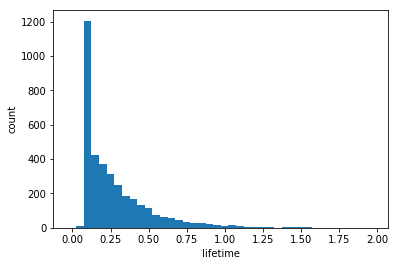

In [11]:
# (optional step)

# check the lifetime distribution

# this step requires the previous one so that `xyt` is defined

dt = .05
_, lifetime = np.unique(xyt['n'], return_counts=True)
t = np.arange(lifetime.max()) # lifetime and t are in number of steps
hist = np.array([ np.sum(lifetime==_t) for _t in t ])

import matplotlib.pyplot as plt

plt.bar(dt * t, hist, dt)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.show()


In [ ]:
# step 2. tessellate

# this step requires step 1. so that `xyt` is defined.

# notes: `strict_min_location_count` makes `tessellate` discard cells with lesser numbers of locations,
#        and this applies before `knn` or `radius`.
#
#        beware that overwriting a mesh deletes the associated further analyses (inferences).

np.random.seed(seed)
try:
    cells = tessellate(xyt, 'random', lower_bound=np.array([0.,0.]), upper_bound=np.array([1.,1.]),
          avg_location_count=400, strict_min_location_count=10,
          knn=knn, radius=radius)
except:
    print('do not forget to run step 1. again')
    raise

# save
if os.path.exists(rwa_file):
    # load the existing analysis tree
    analysis_tree = load_rwa(rwa_file)
    
    if not overwrite and mesh_label in analysis_tree: # prevent overwriting
        if mesh_label_index:
            print('suffixed label already exists for the mesh; you may skip this step')
            raise ValueError('please either set `mesh_label_index` to None or `overwrite` to True')
        # if a mesh already exists for the defined label, generate a new label so that the
        # existing mesh is not overwritten.
        mesh_label = analysis_tree.autoindex(mesh_label + '-*')
        print('the actual label for the mesh is: {}'.format(mesh_label))
        print("if you expect to work on this mesh after running step 0. again,\nplease set `mesh_label_index` in step 0. to: '{}'".format(mesh_label.split('-')[-1]))
        
else:
    # make a new analysis tree
    analysis_tree = Analyses(xyt)
    print('writing file: {}'.format(rwa_file))
analysis_tree.add(cells, label=mesh_label)
save_rwa(rwa_file, analysis_tree, force=True)


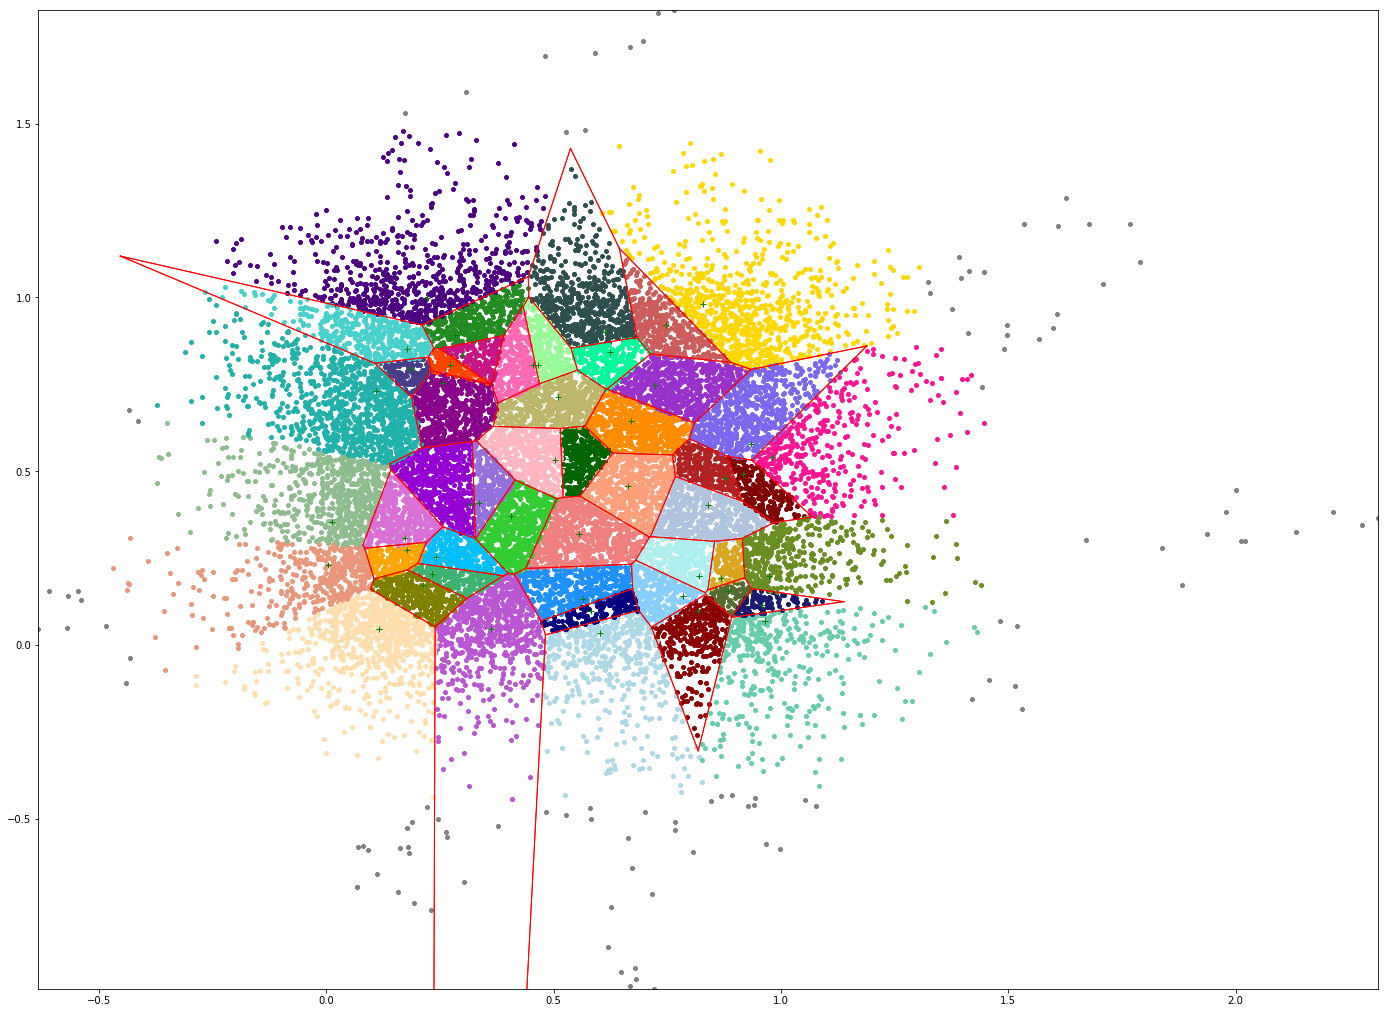

In [12]:
# plot the mesh from the rwa file

cell_plot(rwa_file, label=mesh_label)

In [13]:
# (optional step)

# export the mesh to a .cluster file

from tramway.utils.inferencemap import export_file

cluster_basename = '_'.join((os.path.splitext(trajectory_file)[0], mesh_label))
cluster_file = cluster_basename + '.cluster'

export_file(rwa_file, mesh_label, cluster_file=cluster_file)

# print command to run inferenceMAP on the generated file

vmesh_basename = '_'.join((cluster_basename, maps_label))
vmesh_file = vmesh_basename + '.vmesh'

print('./inferenceMAP -i {} -o {} -m DV -e {} -d {:.0f} -v {:.0f} -j {:d}'.format(cluster_file, vmesh_file,
        int(round(localization_error*1e3)), diffusivity_smoothing, potential_smoothing, int(jeffreys_prior)))


./inferenceMAP -i f_0_d_005_r_0.5.cluster -o f_0_d_005_r_0.5_sigma_0_d_0_v_0_j_0.vmesh -m DV -e 0 -d 0 -v 0 -j 0


In [14]:
# step 3. infer D and V

# to try different values of the inference parameters, edit and run step 0.
# and then run this step directly.

t0 = time.time()

np.random.seed(seed)
infer(rwa_file, 'DV', max_iter=max_iter,
     localization_error=localization_error,
     diffusivity_prior=diffusivity_smoothing,
     potential_prior=potential_smoothing,
     jeffreys_prior=jeffreys_prior,
     input_label=mesh_label, output_label=maps_label)

# take a break

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

/home/francois/github/TRamWAy/tramway/inference/dv.py:256: OptimizationWarning: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  warn('{}'.format(result.message), OptimizationWarning)


elapsed time: 1965s


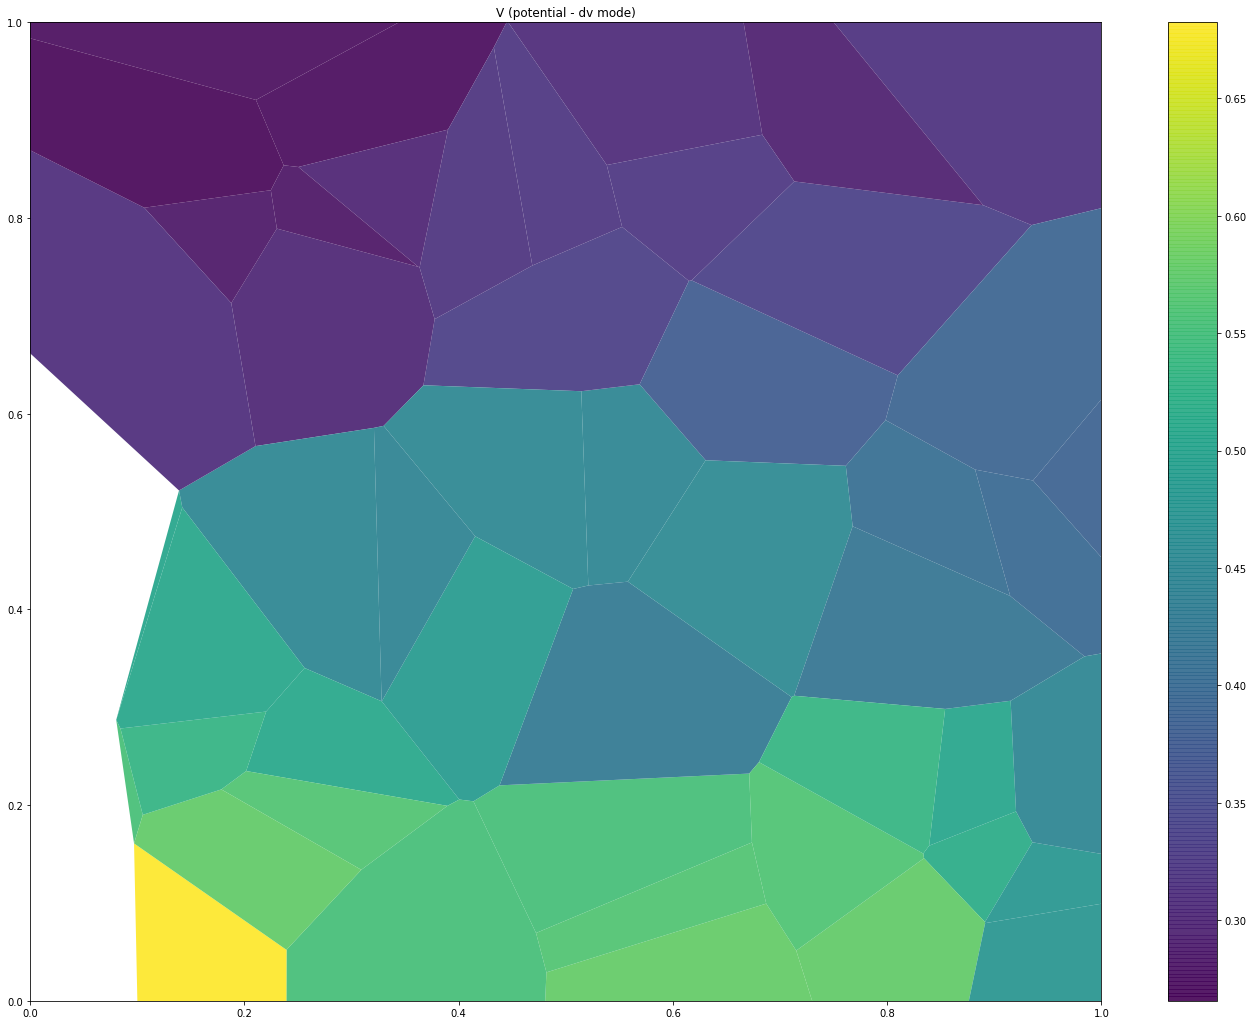

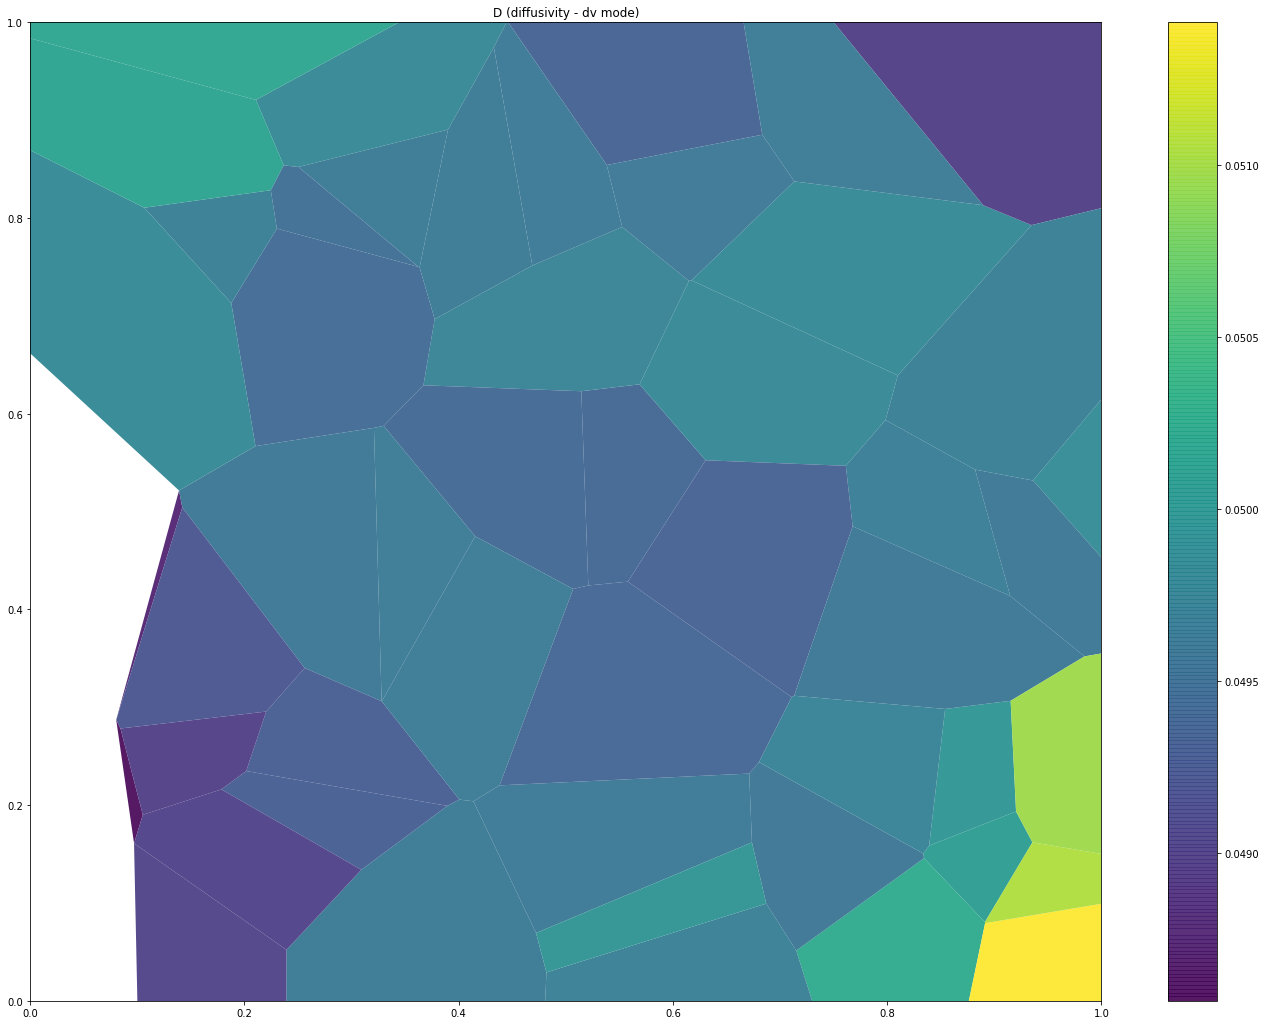

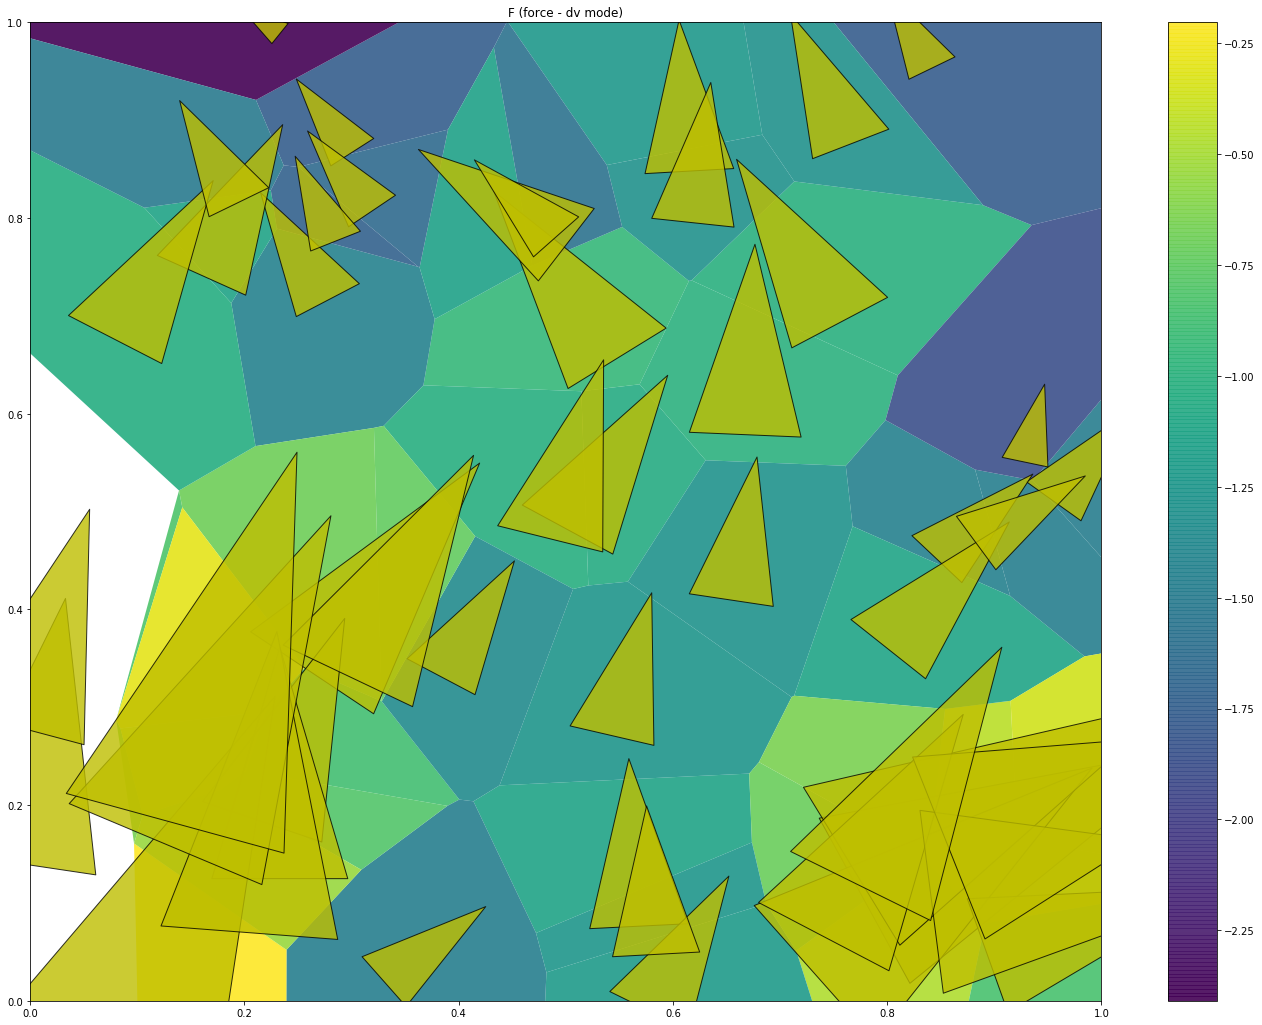

In [16]:
# plot the maps

map_plot(rwa_file, label=(mesh_label, maps_label), xlim=[0.,1.], ylim=[0.,1.])

# notes: the colour-coded map for the force is the log-amplitude.
#
#        the current TRamWAy version does not properly draw the peripheral cells
#        that are open.

In [17]:
# (optional step)

# export the maps to a .vmesh file

from tramway.utils.inferencemap import export_file

cluster_basename = '_'.join((os.path.splitext(trajectory_file)[0], mesh_label))
cluster_file = cluster_basename + '.cluster'
vmesh_basename = '_'.join((cluster_basename, maps_label))
vmesh_file = vmesh_basename + '_tramway.vmesh'

export_file(rwa_file, (mesh_label, maps_label), vmesh_file=vmesh_file, auto=True)


In [18]:
# (optional step)

# print variables

for v in ('seed', 'D', 'F', 'tau', 'radius', 'knn', 'overwrite', 'mesh_label_index', 'localization_error',
         'diffusivity_smoothing', 'potential_smoothing', 'jeffreys_prior', 'max_iter', 'trajectory_file',
         'rwa_file', 'mesh_label', 'maps_label'):
    print('{}:\t{}'.format(v, eval(v)))


seed:	123456789
D:	0.05
F:	None
tau:	0.25
radius:	0.5
knn:	None
overwrite:	False
mesh_label_index:	None
localization_error:	0
diffusivity_smoothing:	0.0
potential_smoothing:	0.0
jeffreys_prior:	False
max_iter:	500
trajectory_file:	f_0_d_005.txt
rwa_file:	f_0_d_005.rwa
mesh_label:	r_0.5
maps_label:	sigma_0_d_0_v_0_j_0
